In [1]:
import matplotlib.pyplot as plt

In [5]:
from glob import glob
import numpy as np 
from sklearn.decomposition import PCA
import cv2

import torch
import torch.nn as nn
from torch.utils import data

import torch.multiprocessing as mp
from thomas_detector import ThomasDetector, get_piece_mask
from puzzle_grid import PuzzleGrid, get_xy_min

device = 'cpu'
torch.hub.load('rwightman/gen-efficientnet-pytorch', 'tf_efficientnet_b2_ns', pretrained=True)

name = 'efficientnetTune5_epoch10'
# model = torch.load('/home/me134/me134ws/src/HW1/vision/checkpoints/efficientnetTune5_epoch10.cp', map_location=torch.device('cpu')).eval().to(device)
model = torch.load('../vision/checkpoints/efficientnetTune5_epoch10.cp', map_location=torch.device('cpu')).eval().to(device)
MODEL_OUT_DIM = 512
vision_dir = '../vision'

Using cache found in C:\Users\Thomas/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


In [74]:

def run_model(img, image_size = 124):
    # import matplotlib.pyplot as plt
    # plt.imshow(img)
    # plt.show()
    img = cv2.resize(img, (image_size, image_size))
    img = (img - img.mean()) / img.std()
    # img = ((img / 255.0) - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    ref = torch.from_numpy(img[:image_size, :image_size, :].reshape(1, image_size, image_size, 3)).float().permute(0, 3, 1, 2).to(device)
    ref_pred = model(ref)
    return ref_pred.cpu().detach().numpy()

def run_model_masked(img, image_size = 124):
    img = cv2.resize(img, (image_size, image_size))
    mask = get_piece_mask(img).reshape((image_size, image_size, 1)) > 128
    img = img * mask
    img = (img - img.mean()) / img.std()
    # img = ((img / 255.0) - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    ref = torch.from_numpy(img[:image_size, :image_size, :].reshape(1, image_size, image_size, 3)).float().permute(0, 3, 1, 2).to(device)
    ref_pred = model(ref)
    return ref_pred.cpu().detach().numpy()

def calc_iou(img1, img2, image_size = 124):
    img1 = cv2.resize(img1, (image_size, image_size))
    mask1 = get_piece_mask(img1)> 128
    img2 = cv2.resize(img2, (image_size, image_size))
    mask2 = get_piece_mask(img2) > 128
    
    return (mask1 * mask2).sum() / (mask1.sum() + mask2.sum())

def cvt_color(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

class VisionMatcher():
    def __init__(self, base_image_path, width_n = 5, height_n = 4):
        self.base_img = cvt_color(cv2.imread(base_image_path))
        self.detector = ThomasDetector()
        self.detector.process(self.base_img)
        self.pieces = self.detector.pieces
        
        self.width_n = width_n
        self.height_n = height_n
        
        self.puzzle_grid = PuzzleGrid(
            width_n = width_n, height_n = height_n, spacing_height = 1.0/(height_n-1), spacing_width = 1.0/(width_n-1), offset_x = 0, offset_y = 0
        )
        
        self.max_x = np.max([p.x for p in self.pieces])
        self.min_x = np.min([p.x for p in self.pieces])
        self.max_y = np.max([p.y for p in self.pieces])
        self.min_y = np.min([p.y for p in self.pieces])

        self.piece_grid = [[None for j in range(height_n)] for i in range(width_n)]

        def scale_x(x):
            return (x - self.min_x) / (self.max_x - self.min_x)
        def scale_y(y):
            return (y - self.min_y) / (self.max_y - self.min_y)
        
        for piece in self.pieces:
            if (piece.is_valid()):
                (x_close, y_close) = get_xy_min(((self.puzzle_grid.grid_centers - np.array([scale_x(piece.x), scale_y(piece.y)]))**2).sum(axis = 2))
                self.piece_grid[x_close][y_close] = piece
        
        
        self.inferences = np.zeros((width_n, height_n, MODEL_OUT_DIM))
        
        for row in range(width_n):
            for col in range(height_n):
                piece = self.piece_grid[row][col]
                if(piece == None):
                    print("Missing piece", (row, col))
                else:
                    val = piece.natural_img * (piece.img.reshape(piece.img.shape[0], piece.img.shape[1], 1) > 128)
                    self.inferences[row, col] = run_model(val)
        
        self.fit_rotation_pca()
            
    def calculate_xyrot(self, img):
        sims = np.zeros((self.width_n, self.height_n, 4))
        for k in range(4):
            sims[:, :, k] = ((self.inferences - run_model(np.rot90(img, k = k))) ** 2).sum(axis = 2)
        
        xy_min = get_xy_min(sims[:, :].mean(axis = 2))

        base = self.piece_grid[xy_min[0]][xy_min[1]].natural_img
        ious = [calc_iou(np.rot90(img, k = k), base) for k in range(4)]
        argmin_basic = np.argmin(sims[xy_min[0], xy_min[1], :4])
        argmin_iou = np.argmin(ious)
        sim_base = self.inferences[xy_min[0]][xy_min[1]]
        sims_rot = ((self.rotation_pca.transform(self.calculate_rotation_vectors(img).T) - self.rotation_pca.transform(sim_base.reshape(1,-1))) ** 2).sum(axis=1)
        argmin_pca = np.argmin(sims_rot)
        return xy_min, argmin_pca
    
    def calculate_rotation_difference_vectors(self, img, ref):
        sims = np.zeros((MODEL_OUT_DIM, 4))
        ref_inference = run_model_masked(ref)
        for k in range(4):
            sims[:, k] = (ref_inference - run_model_masked(np.rot90(img, k = k)))
        
        return sims
    
    def calculate_rotation_vectors(self, img):
        sims = np.zeros((MODEL_OUT_DIM, 4))
        for k in range(4):
            sims[:, k] = (run_model_masked(np.rot90(img, k = k)))
        return sims

    def fit_rotation_pca(self, dims = 15):
        imgs = glob(f'{vision_dir}/imgs/good1*.jpg')
        all_vectors = []
        for path in imgs:
            img = cvt_color(cv2.imread(path))
            vectors = self.calculate_rotation_vectors(img).T
            for v in vectors:
                all_vectors.append(v)

        all_vectors = np.array(all_vectors)
        self.rotation_pca = PCA(dims).fit(all_vectors)

    def fit_rotation_logistic(self):
        pass

    def fit_pca(self, dims = 5):
        all_vectors = []
        for piece in self.pieces:
            img = piece.img
            v = run_model_masked(img)
            all_vectors.append(v)

        all_vectors = np.array(all_vectors)
        self.pca = PCA(dims).fit(all_vectors)

In [75]:
matcher = VisionMatcher('C:/Code/CS134/HW1/done_exploded_colored2.jpg')

((4, 1), 1)


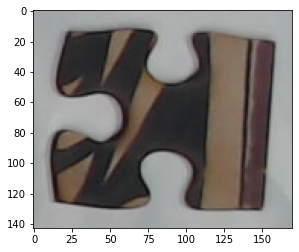

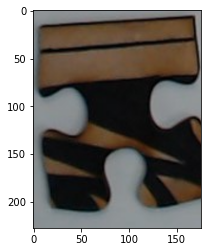

In [76]:
path = '../vision/p9.png'
cors = matcher.calculate_xyrot(cvt_color(cv2.imread(path)))
print(cors)
plt.imshow(matcher.piece_grid[cors[0][0]][cors[0][1]].natural_img)
plt.show()
plt.imshow(np.rot90(cvt_color(cv2.imread(path)), k = cors[1]))
plt.show()

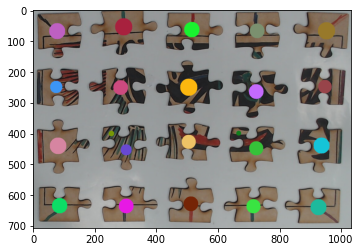

In [77]:
plt.imshow(matcher.base_img)

((0, 3), 0)


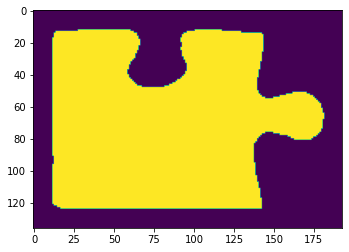

In [78]:
cors = matcher.calculate_xyrot(cvt_color(cv2.imread('../vision/done_exploded2.jpg'))[150:270, 30:170])
print(cors)
plt.imshow(matcher.piece_grid[cors[0][0]][cors[0][1]].img)

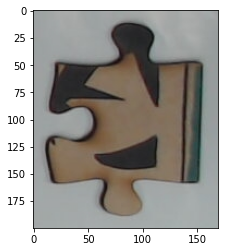

In [79]:
plt.imshow(matcher.piece_grid[4][2].natural_img)

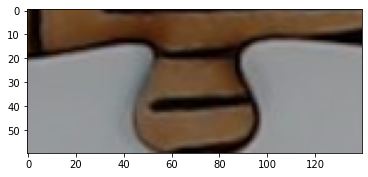

In [80]:
plt.imshow(cvt_color(cv2.imread('../vision/p10.png'))[150:270, 30:170])

In [81]:
good1s = glob('../vision/imgs/good1_*')
good2s = [g.replace('good1', 'good2') for g in good1s]



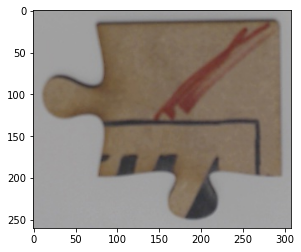

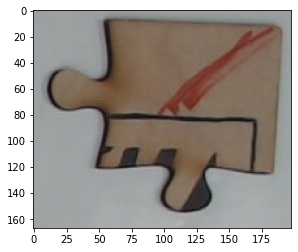

2 2 0


In [91]:
i = 16



img = cvt_color(cv2.imread(good1s[i]))
base = cvt_color(cv2.imread(good2s[i]))


sim_base = run_model_masked(base)
sims_rot = ((matcher.rotation_pca.transform(matcher.calculate_rotation_vectors(img).T) - matcher.rotation_pca.transform(sim_base.reshape(1,-1))) ** 2).sum(axis=1)
argmin_pca = np.argmin(sims_rot)

ious = [calc_iou(np.rot90(img, k = k), base) for k in range(4)]
argmin_basic = np.argmin((matcher.calculate_rotation_difference_vectors(img, base) ** 2).sum(axis = 0))
argmin_iou = np.argmin(ious)

plt.imshow(np.rot90(cvt_color(cv2.imread(good1s[i])), k = 2))
plt.show()
plt.imshow((cvt_color(cv2.imread(good2s[i]))))
plt.show()

print(argmin_pca, argmin_basic, argmin_iou)

In [23]:
all_vectors = []
for i in range(len(good1s)):
    img = cvt_color(cv2.imread(good1s[i]))
    base = cvt_color(cv2.imread(good2s[i]))
    vectors = matcher.calculate_rotation_difference_vectors(img, base).T
    for v in vectors:
        all_vectors.append(v)
all_vectors = np.array(all_vectors)
pca = PCA(10).fit(all_vectors)

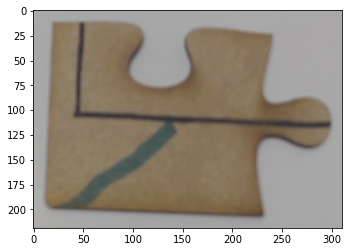

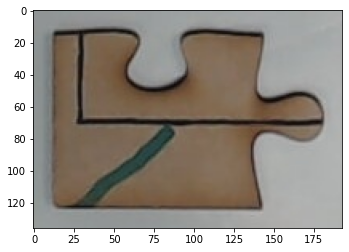

[[ 1.47787545  0.72413717  1.71837143 -0.81773507 -3.50959836  1.166
  -0.47747171 -0.72227347  0.75556659  1.05349572]
 [ 2.01667652  0.72584072  1.02333129 -1.92488231 -4.14963466  1.74355098
   0.45753376  0.15814648  0.4841876  -0.88842823]
 [ 2.16715965  0.09517083  2.92492141 -1.43614815 -4.09336762  0.71065919
  -0.13275376  0.86561823  1.31440281  0.4440314 ]
 [ 1.77007515 -2.83602372  2.13973727 -1.31358626 -3.88967554  0.82932959
   0.55571676  0.70606889  1.76613126  1.13398283]]
[[-0.33434037  1.29872443 -0.34852363  2.15761295 -0.75013871  0.59233541
  -0.0520603  -1.28403943 -0.53619606  0.7421127 ]
 [-0.24550015  0.87859066  0.63219539  3.61032612 -0.44065638  2.09425792
  -1.49092599 -0.73351122 -0.19657859  0.81569031]
 [-0.13196449  2.01689581 -0.12158822  2.68554867 -0.73828135  1.60357327
  -0.95494782 -0.98262371  0.16806739  1.2515602 ]
 [ 0.84830412  3.31282569  0.83994561  2.97575236 -0.73310693  1.53055859
  -0.89963102 -0.6760849   0.1319477   0.35983193]]


In [24]:
i = 12


plt.imshow(np.rot90(cvt_color(cv2.imread(good1s[i])), k = 0))
plt.show()
plt.imshow((cvt_color(cv2.imread(good2s[i]))))
plt.show()

img = cvt_color(cv2.imread(good1s[i]))
base = cvt_color(cv2.imread(good2s[i]))
vectors = matcher.calculate_rotation_vectors(base).T
print(pca.transform(vectors))

vectors2 = matcher.calculate_rotation_difference_vectors(img, base).T
print(pca.transform(vectors2))

In [25]:
((vectors2 - vectors[0]) ** 2).sum(axis = 1)

array([50.42994837, 65.2149891 , 54.16922398, 47.6076895 ])

In [26]:
((pca.transform(vectors2) - pca.transform(vectors)[0]) ** 2).sum(axis = 1)

array([26.9449023 , 36.05179895, 28.47307678, 31.15207647])

In [27]:
((pca.transform(vectors2)) ** 2).sum(axis = 1)

array([ 9.97850531, 22.3113047 , 17.90086953, 25.548416  ])

In [28]:
[calc_iou(np.rot90(img, k = k), base) for k in range(4)]

[0.47238421955403087,
 0.37724413950829044,
 0.33727844482561464,
 0.3706689536878216]